In [9]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.utils import resample
from sklearn.metrics import r2_score, ndcg_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

from scipy.stats import spearmanr

import sys
sys.path.append('..')
from util.Datasets import *
from util.model import *

def ndcg(y_true, y_pred):
    #y_true_normalized = (y_true - y_true.mean()) / y_true.std()
    #y_true_normalized = y_true_normalized - min(y_true_normalized)
    y_true_normalized = y_true - min(y_true)
    #y_pred_normalized = y_pred - min(y_pred)
    #y_pred_normalized = (y_pred - y_pred.mean()) / y_pred.std()
    return ndcg_score(y_true_normalized.reshape(1, -1), y_pred.reshape(1, -1))

font = {'family' : 'arial',
        'size'   : 14}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

In [ ]:
# FILEPATH = '/home/jyang4/ProtTP/data/AllPredictions.csv'
# dataframe = pd.read_csv(FILEPATH)
# dataset = GB1Dataset(dataframe, 'one-hot', ["Triad-FixedBb-dG", 
#                             "EvMutation",
#                             "esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked"], SD_only = False)

In [ ]:
# #Calculate embeddings if necessary
# with open('/home/jyang4/ProtTP/saved/AE+AD/AE+AD.json', 'r') as f:
#     config = json.load(f)

# model = ProtTP(config["model_config"], dataset)
# model.load_state_dict(torch.load('/home/jyang4/ProtTP/saved/AE+AD/best.pth'))

# with torch.no_grad():
#     X = dataset.X#.to(device)
#     if config["model_config"]["kl_div_weight"] != 0:
#         mu, log_var = model.encode(X)
#         embeddings = model.reparameterize(mu, log_var)
#     else:
#         embeddings = model.encode(X)
#     reconstructions = model.decode(embeddings)

In [10]:
file_name = 'VAE_MSA_v2'

FILEPATH = '/home/jyang4/ProtTP/data/PABP_AllPreds.csv'
dataframe = pd.read_csv(FILEPATH)
attribute_names = ['EVMutation', 'ESM_ensemble'] #'ESM_ensemble'"EVMutation"
dataset = PABPDataset(dataframe = dataframe, encoding = 'one-hot', attribute_names = attribute_names)
dataset.encode_X()

embeddings = np.load('/home/jyang4/ProtTP/saved/{}/embeddings.npy'.format(file_name))
#embeddings2 = np.load('/home/jyang4/ProtTP/saved/AE+AD_PABP_fullDSM/embeddings.npy')
log_probs = pd.read_csv('/home/jyang4/ProtTP/saved/{}/log_probs.csv'.format(file_name))
likelihoods = np.load('/home/jyang4/ProtTP/saved/{}/likelihoods.npy'.format(file_name))

SpearmanrResult(correlation=-0.029929681586942408, pvalue=1.0598223222905139e-08)


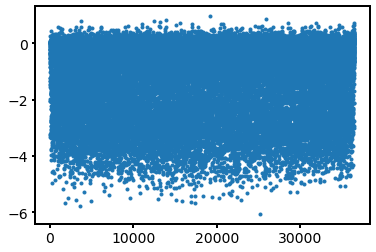

In [11]:
dataframe['log_prob'] = log_probs['log_prob']
print(spearmanr(np.array(dataframe['log_fitness']), np.array(dataframe['log_prob'])))
plt.plot(log_probs['log_prob'].rank(ascending=False), dataframe['log_fitness'], '.')

In [ ]:
# FILEPATH = '/home/jyang4/ProtTP/data/GB1_AllPreds.csv'
# dataframe = pd.read_csv(FILEPATH)
# dataset = GB1Dataset(dataframe = dataframe, encoding = 'one-hot', attribute_names = ["Triad-FixedBb-dG"], rank_attributes = True)
# dataset.generate_onehot()
# embeddings = np.load('/home/jyang4/ProtTP/saved/AE+Triad_rank_GB1/embeddings.npy')

In [12]:
model_params = {"booster": "gbtree",
                      "tree_method": "exact",
                      "nthread": 1,
                      "objective": "reg:tweedie",
                      "tweedie_variance_power": 1.5,
                      "eval_metric": "tweedie-nloglik@1.5",
                      "eta": 0.3,
                        "max_depth": 6,
                        "lambda": 1,
                        "alpha": 0
                      }

linear = True
# model_params = {"booster": "gblinear",
#                       "tree_method": "exact",
#                       "nthread": 1,
#                       "verbosity": 0,
#                       "objective": "reg:tweedie",
#                       "tweedie_variance_power": 1.5,
#                       "eval_metric": "tweedie-nloglik@1.5"}

In [ ]:
#how listgarten split their dataset
# data = dataset.data.sample(frac=1.0, random_state=0)
# test = data.sample(frac=0.2, random_state=0)
# test

In [13]:
#downstream supervised regression
N_models = 100
N_train_samples = 96

#only necessary if you are testing the top 96, otherwise defaults to a fixed test set
N_test_samples = 96
alpha_list = [1]
#alpha_list = [10**2.5]
#alpha_list = [5**i for i in range(-5,5)]


X_baseline = np.array(dataset.X)
X_embed = np.array(embeddings)
#X_embed = np.array(likelihoods)

X_OHembed = np.concatenate((np.array(dataset.X), np.array(embeddings)), axis=1)

X_zs = np.array(dataset.attributes)

X_OHzs = np.concatenate((np.array(dataset.X), np.array(dataset.attributes)), axis=1)
#X_OHzs = np.concatenate((np.array(dataset.X), np.array(log_probs['log_prob']).reshape(-1, 1)), axis=1)
#X_OHzs = np.concatenate((np.array(dataset.X), np.array(dataframe['EVMutation']).reshape(-1,1)), axis=1)

X_all = np.concatenate((np.array(dataset.X), np.array(dataset.attributes), np.array(embeddings)), axis=1)

#X_zs = np.array(dataframe['EVMutation']).reshape(-1,1)

inputs = [X_baseline, X_embed, X_zs, X_OHembed, X_OHzs, X_all]
#inputs = [X_OHzs]

results_ndcg = np.zeros((N_models, len(inputs), len(alpha_list)))
results_rho = np.zeros((N_models, len(inputs), len(alpha_list)))
np.random.seed(42)

for k, alpha in enumerate(alpha_list):
    for j, X in enumerate(inputs):
        #do not normalize! it will break the OH+ZS results!
        #scaler = StandardScaler()
        #X = scaler.fit_transform(X)
        #y = dataset.y
        y = dataframe['log_fitness'].values

        seed = 0
        X, y = shuffle(X, y, random_state=seed)
        X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        #print(len(y_test))

        np.random.seed(42)
        for i in range(N_models):
            X_train, y_train = resample(X_train_all, y_train_all, n_samples=N_train_samples)
            #only run this line if you wish to use a different test size
            #X_test, y_test = resample(X, y, n_samples=N_test_samples)

            if linear:
                clf = Ridge(alpha=alpha)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
            else:
                #insert kfold cross validation
                train_matrix = xgb.DMatrix(X_train, label = y_train)

                # in reality we should use a validation set, not the test set
                test_matrix = xgb.DMatrix(X_test, label = y_test)
                evallist = [(train_matrix, "train"), (test_matrix, "test")]
                bst = xgb.train(model_params, train_matrix, num_boost_round=1000, early_stopping_rounds=10, evals=evallist, verbose_eval=False)
                best = bst.best_iteration
                y_pred_test = bst.predict(xgb.DMatrix(X_test), iteration_range=(0,best))

                # y_pred = bst.predict(xgb.DMatrix(X), iteration_range=(0,best))
                # df = pd.DataFrame(X)
                # df['y_pred'] = y_pred
                # df['y'] = y
                # df = df.sort_values('y_pred',ascending = False)
                # df =df.reset_index()
                # y_pred_top = df.loc[:N_test_samples-1,'y_pred'].values
                # y_top = df.loc[:N_test_samples-1,'y'].values

            #results_ndcg[i, j] = ndcg(y_top, y_pred_top)
            #results_rho[i, j] = spearmanr(y_top, y_pred_top)[0]

            results_ndcg[i, j, k] = ndcg(y_test, y_pred_test)
            results_rho[i, j, k] = spearmanr(y_test, y_pred_test)[0]

            #exponentiate if the fitness was logged
            #results_ndcg[i, j, k] = ndcg(np.exp(y_test), np.exp(y_pred_test))
            #results_rho[i, j, k] = spearmanr(np.exp(y_test), np.exp(y_pred_test))[0]

In [ ]:
#for testing individual models
# scaler = StandardScaler()
# X = scaler.fit_transform(X_baseline)
# y = dataset.y

# X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# X_train, y_train = resample(X_train_all, y_train_all, n_samples=N_train_samples, random_state=0)
# #print(spearmanr(X_train, y_train)[0])

# clf = Ridge(alpha=1)
# clf.fit(X_train, y_train)
# y_pred_test = clf.predict(X_test)
# print(spearmanr(y_pred_test, y_test)[0])

In [ ]:
#for visualizing the optimal hyperparameters
#plt.plot(np.log10(alpha_list), np.mean(results_rho, axis = 0).T, '-')

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


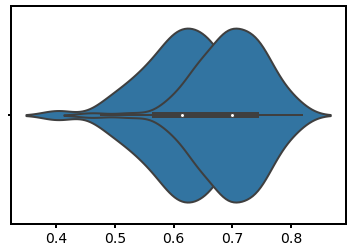

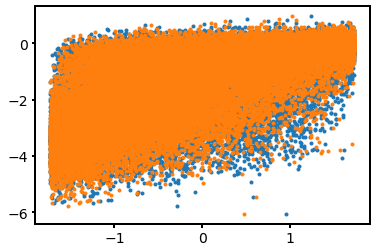

In [14]:
data = dataset.data
all_all_scores = np.array(dataset.attributes)#.reshape(-1)
#all_all_fitness = np.array(dataset.y)#.reshape(-1)#[:100]
all_all_fitness = np.array(dataframe['log_fitness'].values)

ndcgs = np.zeros((N_models, all_all_scores.shape[1]))
rhos = np.zeros((N_models, all_all_scores.shape[1]))
np.random.seed(42)
for j in range(all_all_scores.shape[1]):
    all_scores = all_all_scores[:,j]
    for i in range(N_models):
        scores, fitness = resample(all_scores, all_all_fitness, n_samples=N_train_samples)
        ndcgs[i,j] = ndcg(fitness, scores)
        rhos[i,j] = spearmanr(fitness, scores)[0]

#ax = sns.violinplot(ndcgs)
for i in range(all_all_scores.shape[1]):
    ax = sns.violinplot(rhos[:,i])

plt.figure()
plt.plot(all_all_scores, all_all_fitness, '.')

OH rho           0.516418
 Emb rho         0.501053
ZS rho           0.710837
OH+Emb rho       0.581365
OH+ZS rho        0.751979
OH+Emb+ZS rho    0.749831
dtype: float64


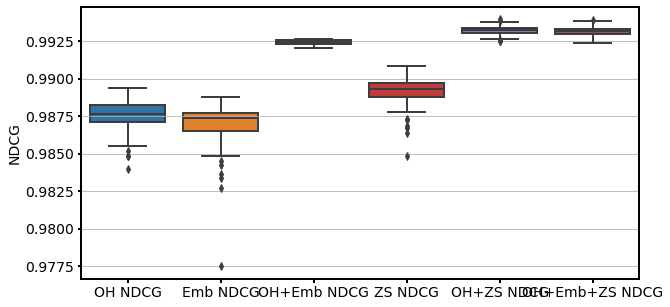

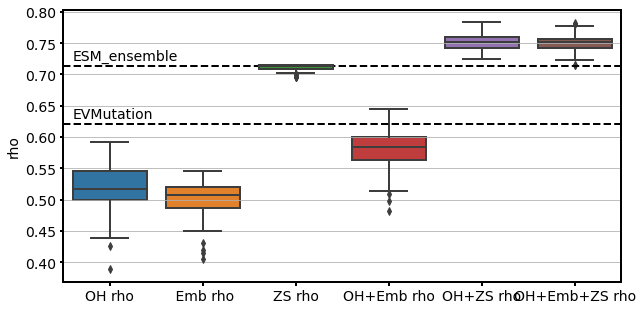

In [15]:
#increasing the NDCG increase ridge model performance
df_ndcg = pd.DataFrame(data=results_ndcg.reshape(100,6), columns= ['OH NDCG', 'Emb NDCG', 'OH+Emb NDCG', 'ZS NDCG', 'OH+ZS NDCG', 'OH+Emb+ZS NDCG'])
df_rho = pd.DataFrame(data=results_rho.reshape(100,6), columns= ['OH rho',' Emb rho', 'ZS rho','OH+Emb rho','OH+ZS rho', 'OH+Emb+ZS rho'])

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.boxplot(data = df_ndcg)
#plt.axhline(y = ndcg(all_all_fitness, all_scores), color = 'k', linestyle = '--')
plt.ylabel('NDCG')
#plt.savefig('384_96_xgb_NDCG.jpg')

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.boxplot(data = df_rho)
for i in range(all_all_scores.shape[1]):
    value = spearmanr(all_all_fitness, all_all_scores[:,i])[0]
    plt.axhline(y = value, color = 'k', linestyle = '--')
    plt.text(-0.4, value+0.01, attribute_names[i])
plt.ylabel('rho')
# value = spearmanr(np.array(dataframe['log_fitness']), np.array(dataframe['log_prob']))[0]
# plt.axhline(y = value, color= 'k', linestyle = '--')
# plt.text(-0.4, value+0.01, 'prob_MSA_VAE')

print(np.mean(df_rho, axis =0))
#plt.savefig('384_96_xgb_rho.jpg')
plt.savefig('figures/boxplot2.eps')


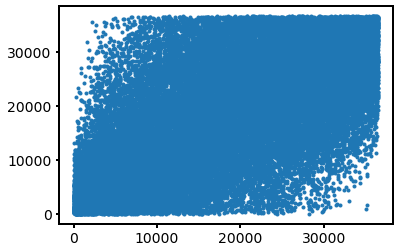

In [8]:
plt.plot(dataset.data['EVMutation'].rank(), dataset.data['log_fitness'].rank(), '.')

In [ ]:
ax = sns.jointplot(x = y_pred_test,y = y_test)
plt.xlabel('Predicted fitness')
plt.ylabel('Actual fitness')

In [ ]:
plt.hist(y_test)
plt.hist(y_pred_test)
plt.yscale('log')